## CV Assignment - 2 (Birds Classification)
## Submitted By: Muhammad Jawad Bashir
## Registration No: 330295


### 1. Mounting Drive

In [2]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
print('Google Drive is mounted\n')
    #print('Google Drive is already mounted\n')

Mounted at /content/gdrive
Google Drive is mounted



###2. Imports

In [3]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for loading datasets
from tensorflow.keras.applications import EfficientNetB1, mobilenet_v2  # Pretrained models from keras
from tensorflow.keras import layers  # for building architectures
from tensorflow.keras import models  # for building architectures
from tensorflow.keras import optimizers # optimizers for training the model
import joblib   # for saving and loading the model
from imutils import paths  # for getting image paths
import matplotlib.pyplot as plt  # for plotting accuracy and other graphs
import seaborn as sns  # for plotting graphs
import pandas as pd  # for handling csv files
import numpy as np  # for performing matrix operations
import random  # for taking random sample and shuffling
import cv2  # for handling image processing functions
import os  # for handling general os related tasks
from glob import glob

### 3. DataLoading & Augmentation Class

In [9]:
# dataset loading and preprocessing class
class DataLoader:
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path

  # Reading filenames from folders
  def read_filenames(self):
    self.fnames = glob(self.dataset_path+"/*/*.jpg")
    print(self.fnames)

  # Creating csv file with image names and labels
  def create_csv(self):
    fnames, classid = [], []
    for f in self.fnames:
      fnames.append(f)
      classid.append(f.split("/")[-2])
    random.shuffle(fnames)
    random.shuffle(classid)
    self.df = pd.DataFrame({"id":fnames, "label":classid})
    print(self.df.head())

  # Helper function for loading the dataset
  def load_dataset(self):
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
      self.data_generator=datagen.flow_from_dataframe(
        dataframe=self.df,
        directory=None,
        x_col="id",
        y_col="label",
        batch_size=64,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(224,224))

### 4. Importing Data

In [10]:
# Loading the train dataset
train_path = "/content/gdrive/MyDrive/birds/train"
traindata = DataLoader(train_path)
traindata.read_filenames()
traindata.create_csv()
traindata.load_dataset()

# Loading the validation dataset
valid_path = "/content/gdrive/MyDrive/birds/valid"
validdata = DataLoader(valid_path)
validdata.read_filenames()
validdata.create_csv()
validdata.load_dataset()

# Loading the test dataset
test_path = "/content/gdrive/MyDrive/birds/test"
testdata = DataLoader(test_path)
testdata.read_filenames()
testdata.create_csv()
testdata.load_dataset()

['/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/120.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/119.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/033.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/087.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/084.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/030.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/078.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/097.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/049.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/028.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/061.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/132.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/043.jpg', '/content/gdrive/MyDrive/birds/train/AFRICAN CROWNED CRANE/045.jpg', '/content/gdrive/MyDrive/birds/tr

### 5. Model 1 - Efficientnet model

In [ ]:
# Model definition - efficientnet from keras applications with imagenet weights for transfer learning
conv_base = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224,3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(315, activation="softmax", name="fc_out"))
conv_base.trainable = False  # Freezing the layers of base model
model.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Training the model
histry1 = model.fit(traindata.data_generator, epochs=10, validation_data=validdata.data_generator)

### 6. Train vs Validation for EfficientNet

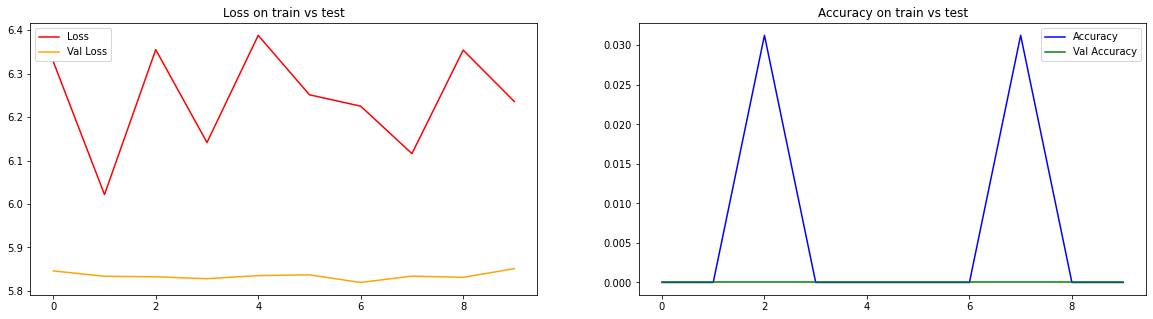

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=histry1.epoch, y=histry1.history['loss'], color='red', label='Loss')
sns.lineplot(x=histry1.epoch, y=histry1.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=histry1.epoch, y=histry1.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=histry1.epoch, y=histry1.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

### 7. EfficientNet Results

In [ ]:
# Evaluating the model on test dataset and calculating the metrics
metrics1 = model.evaluate(testdata.data_generator,verbose=1)
print("Accuracy:", metrics1[1])
print("Precision:", metrics1[2])
print("Recall:", metrics1[3])

 2/50 [>.............................] - ETA: 11:53 - loss: 5.8077 - accuracy: 0.0000e+00 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00

KeyboardInterrupt: ignored

### 8. Quantitative Results for EfficientNet

In [ ]:
# Qualitative results - visualization
# Getting predicitons
testdata.test_generator.reset()
pred=model.predict(testdata.test_generator,verbose=1)
print("pred:", pred.shape)
predicted_class_indices=np.argmax(pred,axis=1)
#print("pred class:", predicted_class_indices)
labels = (traindata.train_generator.class_indices)
print("labels:", labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)
filenames=testdata.test_generator.filenames

# Taking sample of 16 predictions
sample_f=random.sample(filenames, 16)
sample_p=random.sample(predictions, 16)

# Visualization of predictions
imgs, labels = [], []
for f, l in zip(sample_f, sample_p):
  imgs.append(cv2.imread(f))
  labels.append(l)
_, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### 9. Model 2  - Mobilenet_v2 model

In [26]:
mobilenet_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
model2 = models.Sequential()
model2.add(mobilenet_model)
model2.add(layers.Dense(315, activation="softmax", name="fc_out"))
model2.trainable = False 
model2.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

9420800/9406464 [==============================] - 0s 0us/step


In [24]:
# Model definition - efficientnet from keras applications with imagenet weights for transfer learning
conv_base2 = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model2.add(layers.Dropout(0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model2.add(layers.Dense(315, activation="softmax", name="fc_out"))
conv_base2.trainable = False
model2.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training the model
histry2 = model2.fit(traindata.data_generator,
                    validation_data=validdata.data_generator,
                    epochs=2)

### 10. Train vs Validation for MobileNet V2

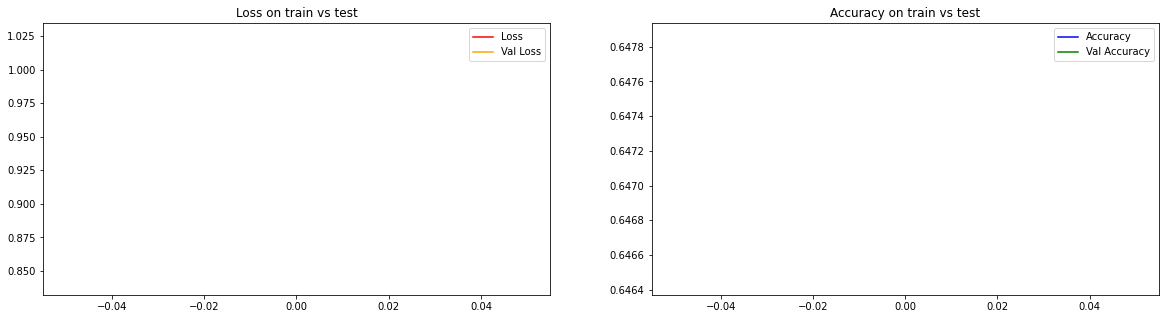

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=histry2.epoch, y=histry2.history['loss'], color='red', label='Loss')
sns.lineplot(x=histry2.epoch, y=histry2.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=histry2.epoch, y=histry2.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=histry2.epoch, y=histry2.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

### 11. MobileNet Accuracy & Quantitative Results

In [ ]:
# Evaluating the model on test dataset and calculating the metrics
metrics2 = model2.evaluate(testdata.data_generator,verbose=1)
print("Accuracy:", metrics2[1])
print("Precision:", metrics2[2])
print("Recall:", metrics2[3])

In [ ]:
# Qualitative results - visualization
# Getting predicitons
testdata.data_generator.reset()
pred=model2.predict(testdata.data_generator,verbose=1)
print("pred:", pred.shape)
predicted_class_indices=np.argmax(pred,axis=1)
#print("pred class:", predicted_class_indices)
labels = (traindata.data_generator.class_indices)
print("labels:", labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)
filenames=testdata.data_generator.filenames

# Taking sample of 16 predictions
sample_f=random.sample(filenames, 16)
sample_p=random.sample(predictions, 16)

# Visualization of predictions
imgs, labels = [], []
for f, l in zip(sample_f, sample_p):
  imgs.append(cv2.imread(f))
  labels.append(l)
_, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### 12. Model Comparison - EfficientNet vs MobileNet for Birds Classification

In [ ]:
print("Metrics for EfficientNet model:")
print("Accuracy:",metrics1[1], "Precision:", metrics1[2], "Recall:", metrics1[3])
print("Metrics for Mobilenet_v2 model:")
print("Accuracy:",metrics2[1], "Precision:", metrics2[2], "Recall:", metrics2[3])

### 13. Model Comparison - EfficientNet vs MobileNet for Birds Classification

In [ ]:
joblib.dump(model, 'birds315_efficientnetb1_clf.pkl')
joblib.dump(model2, 'birds315_mobilenetV2_clf.pkl')